In [2]:
from convexness.convexness import *
import glob
import os
import pandas as pd
from tqdm import tqdm

In [ ]:
folder = 'D:/allopezr/Fragments/vessels_200_obj_ply_no_zipped/vessels_200_obj_ply/'
target_extension = '.obj'
metadata_pattern = '*_mesh.txt'

In [ ]:
# recursive search
path = folder + '*/' + metadata_pattern
mesh_files = glob.glob(folder + '*/' + metadata_pattern, recursive=True)

In [ ]:
mesh_files

In [ ]:
global_df = None

for metadata_file in tqdm(mesh_files):
    df = pd.read_csv(metadata_file, sep='\t', header=0, index_col=False)
    
    # maintain only a subset of the columns
    df = df[['Filename', 'Percentage', 'Vertices', 'Faces']]
    if global_df is None:
        global_df = df
    else:
        global_df = pd.concat([global_df, df], ignore_index=True)

In [ ]:
# create a new column with the number of fragments
global_df['Fragments'] = global_df['Filename'].apply(lambda x: int(x.split('f_')[0].split('_')[-1]))

In [ ]:
# select 1000 random samples from fragments with 4 or less fragments
global_df = global_df[global_df['Fragments'] <= 4]
global_df = global_df.sample(n=10)

In [ ]:
global_df

In [33]:
folders = ['D:/allopezr/Fragments/Vessels_200_Voronoi/', 'D:/allopezr/Fragments/vessels_200_obj_ply_no_zipped/vessels_200_obj_ply/']
target_extension = '.obj'
metadata_pattern = '*_mesh.txt'

results = []

for folder in tqdm(folders):
    # recursive search
    path = folder + '*/' + metadata_pattern
    mesh_files = glob.glob(folder + '*/' + metadata_pattern, recursive=True)
    
    #
    global_df = None
    
    for metadata_file in tqdm(mesh_files):
        df = pd.read_csv(metadata_file, sep='\t', header=0, index_col=False)
        
        # maintain only a subset of the columns
        df = df[['Filename', 'Percentage', 'Vertices', 'Faces']]
        if global_df is None:
            global_df = df
        else:
            global_df = pd.concat([global_df, df], ignore_index=True)
            
    # create a new column with the number of fragments
    global_df['Fragments'] = global_df['Filename'].apply(lambda x: int(x.split('f_')[0].split('_')[-1]))
    # select 1000 random samples from fragments with 4 or less fragments
    global_df = global_df[global_df['Fragments'] <= 6]
    global_df = global_df.sample(n=1000)

    # iterate to calculate the convexness
    for index, row in global_df.iterrows():
        filename = row['Filename']
        fragments = row['Fragments']
        percentage = row['Percentage']
        vertices = row['Vertices']
        faces = row['Faces']
        
        # swap path
        filename = filename.replace('E:/Fragments/', 'D:/allopezr/Fragments/vessels_200_obj_ply_no_zipped/')
        
        mesh = trimesh.load_mesh(filename)
        # normalize the mesh
        mesh.vertices -= mesh.vertices.mean(axis=0)
        mesh.vertices /= np.abs(mesh.vertices).max()
        
        convexness = measure_convexness(mesh, 100, 1)
        global_df.loc[index, 'Convexness'] = convexness
        
    results.append(global_df[['Fragments', 'Convexness']])

100%|██████████| 2/2 [5:35:43<00:00, 10071.52s/it]  


In [34]:
results

[        Fragments  Convexness
 55389           3    0.107475
 70452           5    0.238990
 154153          2    0.339798
 146376          4    0.148283
 8024            4    0.210101
 ...           ...         ...
 161265          5    0.152323
 117983          6    0.497576
 31787           4    0.108687
 46610           4    0.214343
 79318           5    0.371111
 
 [1000 rows x 2 columns],
         Fragments  Convexness
 43724           5    0.352525
 22102           6    0.391919
 37885           6    0.519798
 155384          5    0.195152
 148457          5    0.224242
 ...           ...         ...
 110666          2    0.121818
 87073           4    0.305657
 162454          6    0.205051
 159475          6    0.305455
 106850          4    0.104646
 
 [1000 rows x 2 columns]]

In [35]:
# Change matplotlib style
plt.style.use('default')

font_mapping = {'family': 'Adobe Devanagari', 'weight': 'normal', 'size': 17}
plt.rc('font', **font_mapping)

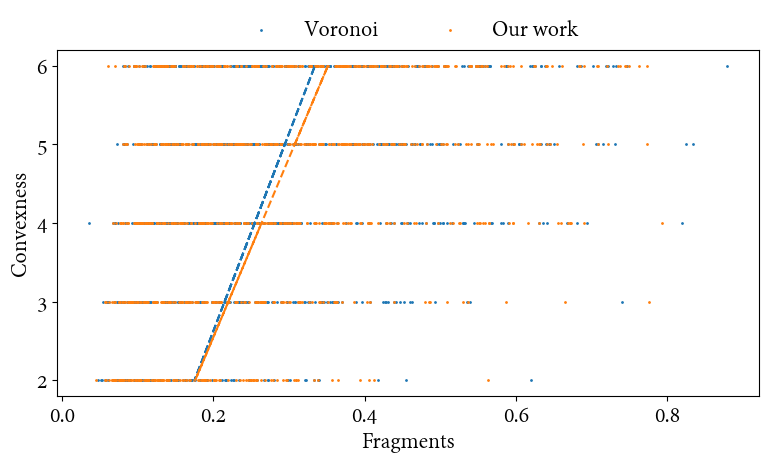

In [45]:
# render the results
import matplotlib.pyplot as plt

legends = ['Voronoi', 'Our work']

plt.figure(figsize=(8, 5))

for df, legend in zip(results, legends):
    plt.scatter(df['Convexness'], df['Fragments'], s=1, label=legend)

for df in results:
    # interpolate the data
    x = df['Fragments']
    y = df['Convexness']
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(p(x), x, '--')

plt.legend(frameon=False, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)
plt.xlabel('Fragments')
plt.ylabel('Convexness')
# x ticks as int
# plt.xticks(np.arange(2, 6, 1))
plt.tight_layout()
plt.show()

In [43]:
# percentil 75, 50, 25
for df in results:
    print(df['Convexness'].quantile([0.25, 0.5, 0.75]))

0.25    0.151515
0.50    0.235455
0.75    0.359596
Name: Convexness, dtype: float64
0.25    0.147020
0.50    0.250606
0.75    0.374040
Name: Convexness, dtype: float64
